See original StyleGAN2 ADA github repo here: https://github.com/NVlabs/stylegan2-ada-pytorch

# Installs

In [1]:
%%time

from IPython.display import clear_output

!pip install -qq pillow
!pip install -qq pyspng ninja imageio-ffmpeg==0.4.3
!git clone https://github.com/PDillis/stylegan3-fun
!pip install -qq gdown
!pip install -qq torch==1.11.0
%cd ./stylegan3-fun

clear_output()

CPU times: user 2.12 s, sys: 523 ms, total: 2.64 s
Wall time: 2min 50s


# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from PIL import Image
import torch.utils.data
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

In [3]:
# Set flags True to include Test set
include_test_set = True

# Load dataframes
train_csv = pd.read_csv("/kaggle/input/fetalhcdata/training_set/training_set_circumference.csv")
if include_test_set:
    test_csv = pd.read_csv("/kaggle/input/fetalhcdata/test_set/test_set_circumference.csv")

# Add 'dataset' column
train_csv['dataset'] = 'train'
if include_test_set:
    test_csv['dataset'] = 'test'

In [4]:
# Define balancing parameters
lower_bound, upper_bound = 6, 33
classes = list(range(lower_bound, upper_bound + 1))

oversample_limit, limit_per_class = 160, 225

In [5]:
def classify_by_HC(df, map_from_zero = False):
    
    def round_classification(value):
        rounded_value = int(np.round(value / 10))
        if rounded_value <= lower_bound:
            return lower_bound
        elif rounded_value > upper_bound:
            return upper_bound
        else:
            return rounded_value

    df['class'] = df['Head_Circumference_mm'].apply(round_classification)

    num_classes = df['class'].nunique()
    
    if map_from_zero:
        # Normalize class labels to start from 0
        unique_classes = sorted(df['class'].unique())
        class_mapping = {old_class: new_class for new_class, old_class in enumerate(unique_classes)}
        df['class'] = df['class'].map(class_mapping)

        return num_classes, class_mapping
    
    return num_classes


# Classify the dataframes
classify_by_HC(train_csv)

if include_test_set:
    classify_by_HC(test_csv)

In [6]:
valid_ratio = 0.2

def stratified_split(df, test_size=0.2, random_state=42):
    train_df, val_df = train_test_split(df, test_size=test_size, stratify=df['class'], random_state=random_state)
    return train_df, val_df

# Split and concatenate the dataframes
labeld_train_df, val_df = stratified_split(train_csv, valid_ratio)
dfs_to_concat = [labeld_train_df]

if include_test_set:
    dfs_to_concat.append(test_csv)

merged_df = pd.concat(dfs_to_concat, ignore_index=True)

In [7]:
# Priority order
priority = ['test', 'train']

for cir_class in classes:
    samples_in_class = merged_df[merged_df['class'] == cir_class]
    
    if len(samples_in_class) == 0:
        print(f"Class {cir_class - lower_bound} has no samples")

    if len(samples_in_class) <= limit_per_class:
        continue

    excess_count = len(samples_in_class) - limit_per_class
    
    for dataset in priority:
        if excess_count <= 0:
            break
        dataset_samples = samples_in_class[(samples_in_class['dataset'] == dataset)]
        if len(dataset_samples) > 0:
            samples_to_remove = min(len(dataset_samples), excess_count)
            excess_samples = dataset_samples.sample(n=samples_to_remove, random_state=42)
            indices_to_keep = ~merged_df.set_index(['dataset', 'filename']).index.isin(excess_samples.set_index(['dataset', 'filename']).index)
            merged_df = merged_df.loc[indices_to_keep]
            excess_count -= samples_to_remove

# Oversample samples in each class until reaching limit_per_class amount of samples
for cir_class in classes:
    samples_in_class = merged_df[merged_df['class'] == cir_class]
    
    if len(samples_in_class) < oversample_limit:
        needed_samples = oversample_limit - len(samples_in_class)
        oversampled_samples = samples_in_class.sample(n=needed_samples, replace=True, random_state=42)
        merged_df = pd.concat([merged_df, oversampled_samples])

filtered_df = merged_df.copy()

# Display the filtered dataframe
filtered_df.head()

,filename,Head_Circumference_cm,Head_Circumference_mm,pixel size(mm),OFD,BPD,mask_filename,dataset,class
0,513_HC.png,17.852,178.52,0.106038,79.2,73.9,513_HC_Mask.png,train,18
1,610_HC.png,19.310,193.10,0.235891,90.2,76.7,610_HC_Mask.png,train,19
2,503_HC.png,16.660,166.60,0.128429,72.5,69.9,503_HC_Mask.png,train,17
3,377_HC.png,17.226,172.26,0.109249,74.7,71.4,377_HC_Mask.png,train,17
4,501_HC.png,17.330,173.30,0.148858,81.3,68.8,501_HC_Mask.png,train,17


In [8]:
num_classes, class_mapping = classify_by_HC(filtered_df, True)
classify_by_HC(val_df, True)
balanced_df = filtered_df.copy()
clear_output()

print("Class Mapping:", class_mapping)
print("Number of Classes:", num_classes)

Class Mapping: {6: 0, 7: 1, 8: 2, 9: 3, 10: 4, 11: 5, 12: 6, 13: 7, 14: 8, 15: 9, 16: 10, 17: 11, 18: 12, 19: 13, 20: 14, 21: 15, 22: 16, 23: 17, 24: 18, 25: 19, 26: 20, 27: 21, 28: 22, 29: 23, 30: 24, 31: 25, 32: 26, 33: 27}
Number of Classes: 28


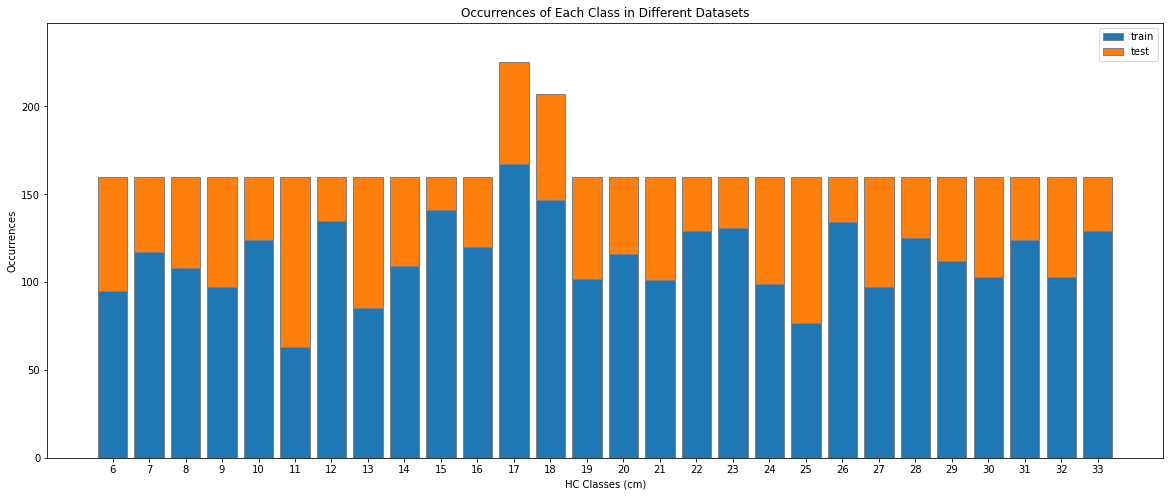

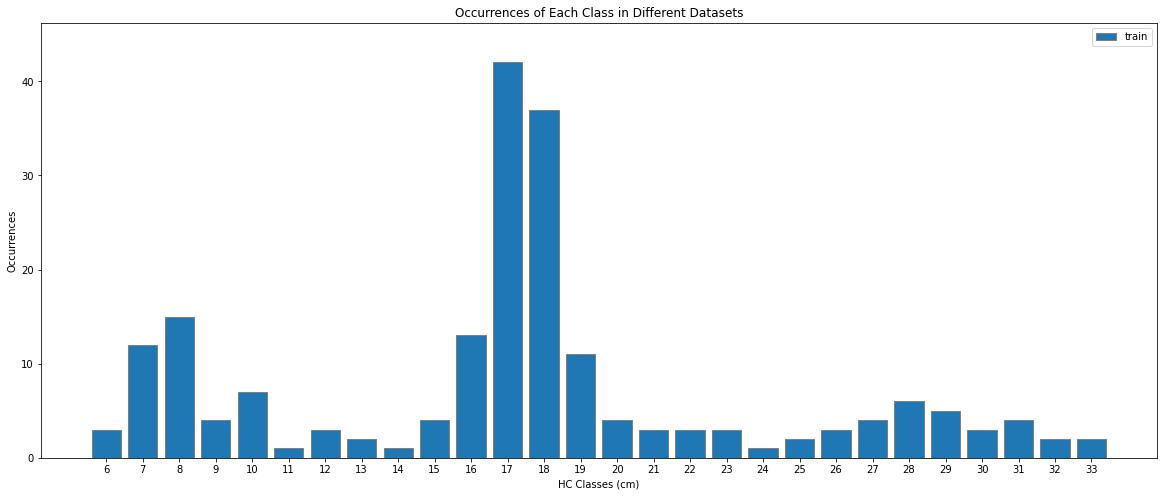

In [9]:
def plot_class_distribution(df, dataset_colors=None):
    # Make a copy of the DataFrame to avoid altering the original
    df_copy = df.copy()
    
    # Identify unique datasets in the 'dataset' column
    unique_datasets = df_copy['dataset'].unique()

    # Initialize a dictionary to hold class counts for each dataset
    class_counts_dict = {}

    # Loop through each unique dataset and count class occurrences
    for dataset in unique_datasets:
        dataset_data = df_copy[df_copy['dataset'] == dataset]
        class_counts = dataset_data['class'].value_counts().sort_index()
        class_counts_dict[dataset] = class_counts

    # Combine the counts into a single DataFrame
    class_counts = pd.DataFrame(class_counts_dict).fillna(0)

    # Plotting
    fig, ax = plt.subplots(figsize=(20, 8))

    # Default colors if dataset_colors is not provided
    default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    if dataset_colors is None:
        dataset_colors = {}
    
    # Bar width
    bar_width = 0.35

    # Initialize bottom for stacked bars
    bottom = None

    for i, dataset in enumerate(class_counts.columns):
        if bottom is None:
            bottom = np.zeros_like(class_counts[dataset])

        # Get color for current dataset
        color = dataset_colors.get(dataset, default_colors[i % len(default_colors)])

        ax.bar(class_counts.index, class_counts[dataset], bottom=bottom, color=color, edgecolor='grey', label=dataset)
        bottom += class_counts[dataset]

    # Add labels
    ax.set_xlabel('HC Classes (cm)')
    ax.set_ylabel('Occurrences')
    ax.set_title('Occurrences of Each Class in Different Datasets')
    ax.legend()

    # Set x-axis tick labels with class numbers
    ax.set_xticks(range(len(class_counts)))
    ax.set_xticklabels(class_counts.index + lower_bound)

    # Increase y-axis limit a little more than the top value
    max_count = class_counts.sum(axis=1).max()
    ax.set_ylim(0, max_count * 1.1)

    # Show plot
    plt.show()

dataset_colors = {'train': '#1f77b4', 'test': '#ff7f0e'}
plot_class_distribution(balanced_df, dataset_colors)
plot_class_distribution(val_df, dataset_colors)

In [16]:
aug_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=512),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomCrop(size=512),
])

def resize_images(image_ps, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Counter for image naming
    image_count = 0
    
    for image_path in tqdm(image_ps, desc="Processing Images", unit="image"):
        try:
            with Image.open(image_path) as img:
                # Apply augmentation transforms
                img = aug_transforms(img)
                
                # Create new filename
                new_file_name = f"image_{image_count}.jpg"
                output_path = os.path.join(save_dir, new_file_name)
                img.save(output_path)
                
                # Increment the image counter
                image_count += 1
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

# Generate paths for the filtered data
dataset_paths = {
    'train': '/kaggle/input/fetalhcdata/training_set/training_set',
    'test': '/kaggle/input/fetalhcdata/test_set/test_set',
}

balanced_df_paths = [
    os.path.join(dataset_paths[dataset], filename)
    for filename, dataset in zip(balanced_df['filename'], balanced_df['dataset'])
]

# Combine the paths and resize images
output_directory = 'new_imgs'
resize_images(balanced_df_paths, output_directory)

Processing Images: 100%|██████████| 4592/4592 [01:50<00:00, 41.57image/s]


In [17]:
!python dataset_tool.py --source=./new_imgs --dest=./datasets/FH.zip

100%|███████████████████████████████████████| 4592/4592 [01:42<00:00, 44.72it/s]


In [4]:
!python train.py --help

Usage: train.py [OPTIONS]

  Train a GAN using the techniques described in the paper "Alias-Free
  Generative Adversarial Networks".

  Examples:

  # Train StyleGAN3-T for AFHQv2 using 8 GPUs.
  python train.py --outdir=~/training-runs --cfg=stylegan3-t --data=~/datasets/afhqv2-512x512.zip \
      --gpus=8 --batch=32 --gamma=8.2 --mirror=1

  # Fine-tune StyleGAN3-R for MetFaces-U using 1 GPU, starting from the pre-trained FFHQ-U pickle.
  python train.py --outdir=~/training-runs --cfg=stylegan3-r --data=~/datasets/metfacesu-1024x1024.zip \
      --gpus=8 --batch=32 --gamma=6.6 --mirror=1 --kimg=5000 --snap=5 \
      --resume=https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-1024x1024.pkl

  # Train StyleGAN2 for FFHQ at 1024x1024 resolution using 8 GPUs.
  python train.py --outdir=~/training-runs --cfg=stylegan2 --data=~/datasets/ffhq-1024x1024.zip \
      --gpus=8 --batch=32 --gamma=10 --mirror=1 --aug=noaug

Options:
  --cfg [stylegan

In [18]:
!python train.py --outdir=./results --snap=5 --img-snap=5 --cfg=stylegan2 --data=./datasets/FH.zip --augpipe=bgc --gpus=2 --metrics=None --gamma=16 --batch=8 --resume=afhqwild512

Creating output directory...

Training options:
{
  "G_kwargs": {
    "class_name": "training.networks_stylegan2.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 8,
      "freeze_layers": 0,
      "freeze_embed": false
    },
    "channel_base": 32768,
    "channel_max": 512,
    "fused_modconv_default": "inference_only"
  },
  "D_kwargs": {
    "class_name": "training.networks_stylegan2.Discriminator",
    "block_kwargs": {
      "freeze_layers": 0
    },
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 32768,
    "channel_max": 512
  },
  "G_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.002
  },
  "D_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.002
  },
  "loss_kwargs": {
    "class_name": "training.loss.StyleGAN2Loss",
    "r1_g

In [19]:
!python calc_metrics.py --metrics=fid50k_full --data=./datasets/FH3.zip --gpus=2 --network=/kaggle/working/stylegan3-fun/results/00002-stylegan2-FH3-gpus2-batch8-gamma10-resume_custom/network-snapshot-000340.pkl

Loading network from "/kaggle/working/stylegan3-fun/results/00002-stylegan2-FH3-gpus2-batch8-gamma10-resume_custom/network-snapshot-000340.pkl"...
Dataset options:
{
  "class_name": "training.dataset.ImageFolderDataset",
  "path": "./datasets/FH3.zip",
  "resolution": 512,
  "use_labels": false
}
Launching processes...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.

Generator             Parameters  Buffers  Output shape        Datatype
---                   ---         ---      ---                 ---     
mapping.fc0           262656      -        [1, 512]            float32 
mapping.fc1           262656      -        [1, 512]            float32 
mapping.fc2           262656      -        [1, 512]            float32 
mapping.fc3           262656      -        [1, 512]            float32 
mapping.fc4           262656      -        [1, 512]            float32 
mapping.fc5           262656      -        [1, 512]            floa

## Generate Synthetic Images
#### The code below is for RGB

In [20]:
%%time

!pip install -qq moviepy

clear_output()

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
gcsfs 2021.11.1 requires fsspec==2021.11.1, but you have fsspec 2022.1.0 which is incompatible.
CPU times: user 269 ms, sys: 63.2 ms, total: 332 ms
Wall time: 21.6 s


In [ ]:
%%time

outdir = './outdir'
os.makedirs(outdir, exist_ok=True)
!python generate.py images --outdir=./outdir --trunc=1 --seeds=0-1999 --network=/kaggle/input/tmpdataset/network-snapshot-000280.pkl

clear_output()

In [22]:
!python dataset_tool.py --source=./outdir/00000-generate-images --dest=./outdir/gan_images.zip

100%|███████████████████████████████████████| 2000/2000 [01:00<00:00, 32.96it/s]


In [ ]:
import zipfile
import cv2

def convert_images_to_grayscale(input_zip_path, output_zip_path):
    # Open the input zip file in read mode
    with zipfile.ZipFile(input_zip_path, 'r') as input_zip:
        # Get the list of file names
        file_names = input_zip.namelist()
        
        # Create a new zip file to store grayscale images
        with zipfile.ZipFile(output_zip_path, 'w') as output_zip:
            # Iterate over each file in the zip with a progress bar
            for file_name in tqdm(file_names, desc="Processing Images", unit="image"):
                # Read image file as bytes and convert to grayscale
                with input_zip.open(file_name) as file:
                    # Convert the image file to a numpy array
                    img_array = np.frombuffer(file.read(), np.uint8)
                    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
                    
                    # Check if the file is a valid image
                    if img is not None:
                        # Convert image to grayscale
                        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                        
                        # Encode the grayscale image to bytes
                        _, gray_img_encoded = cv2.imencode('.png', gray_img)
                        
                        # Write grayscale image to the output zip
                        output_zip.writestr(file_name, gray_img_encoded.tobytes())


# Usage example
input_zip_path = './outdir/gan_images.zip'
output_zip_path = './outdir/grayscale_images.zip'
convert_images_to_grayscale(input_zip_path, output_zip_path)